In [1]:
import torch
from torch.utils.data import DataLoader as torch_dataloader
from torch.utils.data import Dataset as torch_dataset
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt
import skimage
import skimage.io as io
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
import glob
import copy
import pandas as pd

class MyDataset(torch_dataset):
    def __init__(self, path, filenamelist, labellist):
        self.path=path
        self.filenamelist=filenamelist
        self.labellist=labellist
        
    def __len__(self):
        return len(self.filenamelist) #return the number of data points
    
    def __getitem__(self, idx):
        I=io.imread(self.path+self.filenamelist[idx])
        I=skimage.util.img_as_float32(I)
        I = I.reshape(1,I.shape[0],I.shape[1])
        I = torch.tensor(I, dtype=torch.float32)
        I = I.expand(3, I.shape[1],I.shape[2])
        label=torch.tensor(self.labellist[idx], dtype=torch.int64)
        return I, label

def get_dataloader(x):
    df=pd.read_csv(x)
    path='COVID19CTS/'
    dataset = MyDataset(path, df['filename'].values, df['label'].values)
    loader = torch_dataloader(dataset, batch_size=32, num_workers=0, shuffle=True, pin_memory=True)
    return loader

In [2]:
loader_train = get_dataloader('COVID19CTS/train.csv')
loader_val = get_dataloader('COVID19CTS/val.csv')
loader_test = get_dataloader('COVID19CTS/test.csv')

In [3]:
torch.manual_seed(1234)
device = "cuda:0"

In [4]:
import torch.nn as nn
import torchvision.models as models

model = models.resnet18(weights=None)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model.to(device)
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [5]:
# Defining the loss function and the optimizer
criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.0001)

# Training the model
num_epochs = 20
model.train()

best_epoch = 0
best_result = 0

best_model_wts = copy.deepcopy(model.state_dict())

for epoch in range(num_epochs):
    for inputs, labels in loader_train:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()  # Zero the parameter gradients

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

    # After each epoch, check accuracy
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader_val:
            inputs = inputs.to(device)
            labels = labels.to(device)
            #print(labels)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    result = 100 * correct / total
    print('Accuracy of the network after epoch {} is: {}'.format(epoch+1, result))
    if result > best_result:
        best_epoch = epoch
        best_result = result
        best_model_wts = copy.deepcopy(model.state_dict())

model.load_state_dict(best_model_wts)

Accuracy of the network after epoch 1 is: 51.666666666666664
Accuracy of the network after epoch 2 is: 50.0
Accuracy of the network after epoch 3 is: 80.0
Accuracy of the network after epoch 4 is: 81.66666666666667
Accuracy of the network after epoch 5 is: 81.66666666666667
Accuracy of the network after epoch 6 is: 86.66666666666667
Accuracy of the network after epoch 7 is: 85.0
Accuracy of the network after epoch 8 is: 71.66666666666667
Accuracy of the network after epoch 9 is: 90.0
Accuracy of the network after epoch 10 is: 85.0
Accuracy of the network after epoch 11 is: 88.33333333333333
Accuracy of the network after epoch 12 is: 90.0
Accuracy of the network after epoch 13 is: 85.0
Accuracy of the network after epoch 14 is: 93.33333333333333
Accuracy of the network after epoch 15 is: 78.33333333333333
Accuracy of the network after epoch 16 is: 91.66666666666667
Accuracy of the network after epoch 17 is: 91.66666666666667
Accuracy of the network after epoch 18 is: 96.66666666666667
A

<All keys matched successfully>

In [6]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in loader_test:
        inputs = inputs.to(device)
        labels = labels.to(device)
        #print(labels)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
result = 100 * correct / total
print('Accuracy of the network on testing set is: {}'.format(result))

Accuracy of the network on testing set is: 93.0


In [7]:
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

In [8]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)

# Defining the loss function and the optimizer
criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.0001)

# Training the model
num_epochs = 20
model.train()

best_epoch = 0
best_result = 0

best_model_wts = copy.deepcopy(model.state_dict())

for epoch in range(num_epochs):
    for inputs, labels in loader_train:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()  # Zero the parameter gradients

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

    # After each epoch, check accuracy
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader_val:
            inputs = inputs.to(device)
            labels = labels.to(device)
            #print(labels)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    result = 100 * correct / total
    print('Accuracy of the network after epoch {} is: {}'.format(epoch+1, result))
    if result > best_result:
        best_epoch = epoch
        best_result = result
        best_model_wts = copy.deepcopy(model.state_dict())
        
model.load_state_dict(best_model_wts)

Accuracy of the network after epoch 1 is: 93.33333333333333
Accuracy of the network after epoch 2 is: 93.33333333333333
Accuracy of the network after epoch 3 is: 93.33333333333333
Accuracy of the network after epoch 4 is: 88.33333333333333
Accuracy of the network after epoch 5 is: 95.0
Accuracy of the network after epoch 6 is: 96.66666666666667
Accuracy of the network after epoch 7 is: 96.66666666666667
Accuracy of the network after epoch 8 is: 96.66666666666667
Accuracy of the network after epoch 9 is: 76.66666666666667
Accuracy of the network after epoch 10 is: 95.0
Accuracy of the network after epoch 11 is: 96.66666666666667
Accuracy of the network after epoch 12 is: 96.66666666666667
Accuracy of the network after epoch 13 is: 96.66666666666667
Accuracy of the network after epoch 14 is: 96.66666666666667
Accuracy of the network after epoch 15 is: 96.66666666666667
Accuracy of the network after epoch 16 is: 96.66666666666667
Accuracy of the network after epoch 17 is: 96.6666666666666

<All keys matched successfully>

In [9]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in loader_test:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
result = 100 * correct / total
print('Accuracy of the network on testing set is: {}'.format(result))

Accuracy of the network on testing set is: 97.5


In [10]:
from pytorch_grad_cam import GradCAM, EigenCAM, EigenGradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

(224, 224)


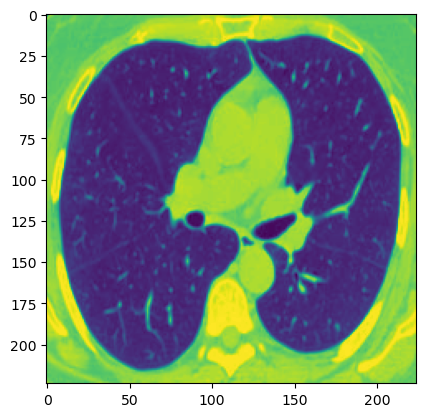

In [11]:
#image=skimage.io.imread('COVID19CTS/COVID/Covid (222).png')
image=skimage.io.imread('COVID19CTS/NORMAL/Non-Covid (222).png')
image=image.astype("float32")
image=image/image.max()
image.shape
print(image.shape)
plt.imshow(image)

(224, 224)
(224, 224, 3)


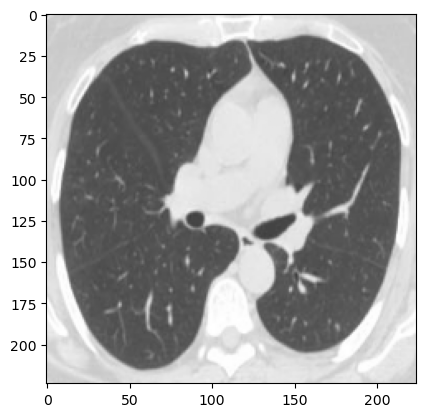

In [12]:
#converting it to rgb
image_gray=image
print(image_gray.shape)
#print(image_gray)
image_gray=image_gray.reshape(224,224,1)
#print(image_gray)
image_color=np.concatenate([image_gray, image_gray, image_gray], axis=2)
print(image_color.shape)
#print(image_color)
plt.imshow(image_color)

In [13]:
#converting numpy array to pytorch tensor
image_input=torch.tensor(image_color).permute(2,0,1) # (224,224,3) to (3,224,224)
image_input=image_input.reshape(1,3,224,224)# a batch that only has one image
image_input.shape

torch.Size([1, 3, 224, 224])

In [14]:
class ClassifierOutputTarget:
    def __init__(self, category):
        self.category = category

    def __call__(self, model_output):
        if len(model_output.shape) == 1:
            return model_output[self.category]
        return model_output[:, self.category]

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
image_input = image_input.to(device)
image_input = image_input.float()
model_output = model(image_input)
model_output.shape
#print(image_input)
#print(model_output)

torch.Size([1, 2])

In [16]:
target_layers = [model.layer4[-1]]
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=False)
targets = [ClassifierOutputTarget(category=1)]
grayscale_cam = cam(input_tensor=image_input, targets=targets)
grayscale_cam.shape

(1, 224, 224)

In [17]:
grayscale_cam=grayscale_cam[0]
grayscale_cam.shape

(224, 224)

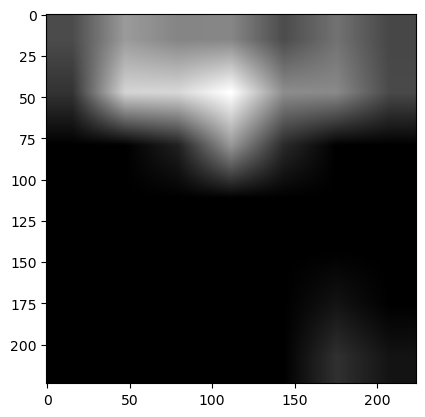

In [18]:
plt.imshow(grayscale_cam, cmap='gray')

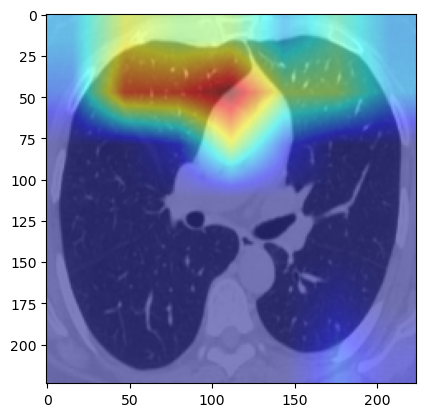

In [19]:
# In this example grayscale_cam has only one image in the batch:
cam_image = show_cam_on_image(image_color, grayscale_cam, use_rgb=True)
cam_image.shape
plt.imshow(cam_image)

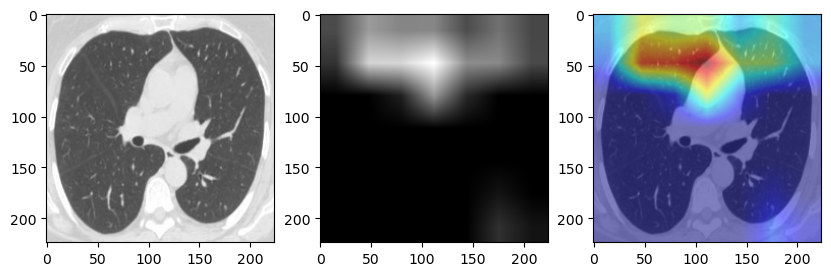

In [20]:
#GradCAM
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=False)
targets = [ClassifierOutputTarget(category=1)]
grayscale_cam = cam(input_tensor=image_input, targets=targets)
grayscale_cam=grayscale_cam[0]
cam_image = show_cam_on_image(image_color, grayscale_cam, use_rgb=True)
fig, ax = plt.subplots(1,3, figsize=(10,10))
ax[0].imshow(image_color)
ax[1].imshow(grayscale_cam, cmap='gray')
ax[2].imshow(cam_image)

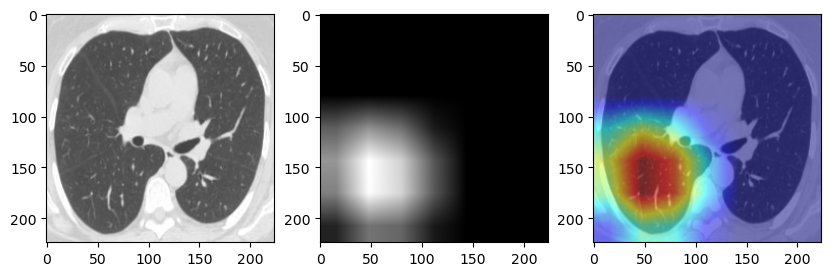

In [21]:
#EigenCAM
cam = EigenGradCAM(model=model, target_layers=target_layers, use_cuda=False)
targets = [ClassifierOutputTarget(category=1)]
grayscale_cam = cam(input_tensor=image_input, targets=targets)
grayscale_cam=grayscale_cam[0]
cam_image = show_cam_on_image(image_color, grayscale_cam, use_rgb=True)
fig, ax = plt.subplots(1,3, figsize=(10,10))
ax[0].imshow(image_color)
ax[1].imshow(grayscale_cam, cmap='gray')
ax[2].imshow(cam_image)

After executing 20 training epochs with the ResNet18 model without pre-loading any weights, a maximum training accuracy was achieved that resulted in a test accuracy of 93.0%. However, when the same process was repeated with pre-loaded weights, the test accuracy increased to 97.5%. Interestingly, this suggests that implementing transfer learning with the pre-trained ResNet18 model does enhance the prediction accuracy.

To gain further insight into the decision-making process of the Convolutional Neural Network (CNN), the PyTorch Grad-CAM tool available at https://github.com/jacobgil/pytorch-grad-cam was used. This tool provides visualizations of the regions in the images that the CNN focuses on to compute the predictions. The visualizations, often referred to as "heat maps", varied significantly depending on the images loaded into the model, indicating diverse areas of interest for different inputs.